In [1]:
import os
# Install java"
# ! sudo apt-get install -y openjdk-8-jdk-headless -qq > /dev/null
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]

In [ ]:
# !java -version
# !free -g

In [ ]:
# !pip install --ignore-installed -q pyspark==2.4.5
# !gsutil cp gs://hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar /opt/conda/lib/python3.7/site-packages/pyspark/jars/
    
# !pip install --ignore-installed spark-nlp==2.5.1
# !pip install wordcloud
# !pip install vaderSentiment

In [2]:
import sparknlp
import json
import os
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession
from sparknlp.annotator import *
from sparknlp.base import *
from pyspark.sql.functions import from_unixtime
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import *
from pyspark.sql.functions import explode, col
from pyspark.sql.functions import from_unixtime, to_date, asc, year, udf, explode, split, col, desc, length, rank, dense_rank, avg, sum
from pyspark.sql.window import Window
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, to_timestamp,date_format
from pyspark import StorageLevel
import pyspark.sql.functions as F
from sparknlp.pretrained import PretrainedPipeline
from collections import Counter
from wordcloud import WordCloud
from sparknlp.base import Finisher, DocumentAssembler
from sparknlp.annotator import (Tokenizer, Normalizer,LemmatizerModel, StopWordsCleaner)
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords

def start():
    builder = SparkSession.builder \
        .appName("Spark NLP Licensed") \
        .master("local[*]") \
        .config("spark.driver.memory", "40G") \
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
        .config("spark.kryoserializer.buffer.max", "2000M") \
        .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.1") \
        .config("fs.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem") \
        .config("fs.AbstractFileSystem.gs.impl", "com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS")
    return builder.getOrCreate()
spark = start()
spark.version
!ps -ef | grep spark

jupyter   1782  1767 44 22:26 ?        00:00:12 /usr/lib/jvm/java-8-openjdk-amd64/bin/java -cp /opt/conda/lib/python3.7/site-packages/pyspark/conf:/opt/conda/lib/python3.7/site-packages/pyspark/jars/* -Xmx40G org.apache.spark.deploy.SparkSubmit --conf spark.master=local[*] --conf spark.driver.memory=40G --conf spark.kryoserializer.buffer.max=2000M --conf spark.jars.packages=com.johnsnowlabs.nlp:spark-nlp_2.11:2.5.1 --conf spark.serializer=org.apache.spark.serializer.KryoSerializer --conf spark.app.name=Spark NLP Licensed --conf fs.AbstractFileSystem.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFS --conf fs.gs.impl=com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem pyspark-shell
jupyter   1950  1767  0 22:26 pts/1    00:00:00 /bin/sh -c ps -ef | grep spark
jupyter   1952  1950  0 22:26 pts/1    00:00:00 grep spark


### WordCloud

In [3]:
nltk.download('stopwords')
eng_stopwords = stopwords.words('english')


def wordcloud(corpus_sdf):
    corpus_pdf = corpus_sdf.limit(500).toPandas()

    corpus_dict = {}
    for index, row in corpus_pdf.iterrows():
        corpus_dict[row['text']] = row['count']
        
    word_cloud = WordCloud().generate_from_frequencies(corpus_dict)
    plt.imshow(word_cloud);
    
    
def remove_stopwords(x):    
    sw = stopwords.words("english")
    string = ''
    for x in x.split(' '):
        if x.lower() not in sw:
            string += x + ' '
    return string


nosw = udf(remove_stopwords)
spark.udf.register("nosw", nosw)

documentAssembler = DocumentAssembler() \
    .setInputCol('text') \
    .setOutputCol('document')

tokenizer = Tokenizer() \
    .setInputCols(['document']) \
    .setOutputCol('token')

# note normalizer defaults to changing all words to lowercase.
# Use .setLowercase(False) to maintain input case.
normalizer = Normalizer() \
    .setInputCols(['token']) \
    .setOutputCol('normalized') \
    .setLowercase(True)

# note that lemmatizer needs a dictionary. So I used the pre-trained
# model (note that it defaults to english)
lemmatizer = LemmatizerModel.pretrained() \
    .setInputCols(['normalized']) \
    .setOutputCol('lemma') \

stopwords_cleaner = StopWordsCleaner() \
    .setInputCols(['lemma']) \
    .setOutputCol('clean_lemma') \
    .setCaseSensitive(False) \
    .setStopWords(eng_stopwords) 

# finisher converts tokens to human-readable output
finisher = Finisher() \
    .setInputCols(['clean_lemma']) \
    .setCleanAnnotations(False)

pipeline = Pipeline() \
    .setStages([
        documentAssembler,
        tokenizer,
        normalizer,
        lemmatizer,
        stopwords_cleaner,
        finisher
    ])

def get_words_from_file(file_path):
    words = []
    with open(file_path) as fo:
        for word in fo:
            words.append(word.strip())
    return set(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]


### Read Tweet Data Set

In [4]:
%%time
spark.conf.set("spark.sql.files.ignoreCorruptFiles", "true")
spark.conf.set("spark.sql.legacy.allowCreatingManagedTableUsingNonemptyLocation","true")

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.43 ms


In [10]:
%%time
tweet_data_bucket_path = "gs://bucket-covid/TweetData/COVID-19-TweetIDs-master/2020-03/"
jan_df = spark.read.json(tweet_data_bucket_path + "coronavirus-tweet-id-2020-03-*-12.jsonl.gz")

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 51.4 s


In [ ]:
# Feb Month tweets
# %%time
# tweet_data_bucket_path = "gs://bucket-covid/TweetData/COVID-19-TweetIDs-master/2020-02/"
# feb_df = spark.read.json(tweet_data_bucket_path + "*.gz")

In [11]:
%%time
jan_df = jan_df.select("id", "created_at",  "coordinates", "geo", "place", "full_text")
jan_df.repartition(20).write.mode('overwrite').saveAsTable("janTweetData")

CPU times: user 12 ms, sys: 0 ns, total: 12 ms
Wall time: 25.9 s


In [13]:
%%time
analyser = SentimentIntensityAnalyzer()
polarity_score = lambda text: analyser.polarity_scores(text)['compound']

CPU times: user 16 ms, sys: 0 ns, total: 16 ms
Wall time: 12.2 ms


### Get polarity from tweet text 

In [14]:
%%time

jan_df = spark.sql("select * from jantweetdata")
nosw = udf(remove_stopwords)
spark.udf.register("nosw", nosw)

udfpolarity = udf(polarity_score)
spark.udf.register("udfpolarity", udfpolarity)

# Select non null and convert to unixtime
jan_df = jan_df.where(col("full_text").isNotNull()) \
            .withColumnRenamed("full_text", "text") \
            .withColumn('created_at', from_unixtime(unix_timestamp(col("created_at"), "EEE MMM dd HH:mm:ss ZZZZ "), "yyyy-MM-dd"))

# Remove stopwords
jan_df = jan_df.withColumn('text', nosw('text'))
# Get polarity of each column
jan_df = jan_df.withColumn('polarity', udfpolarity("text"))

polairty_df = jan_df.select("id", "created_at", "coordinates", "geo", "place", "text", "polarity")
polairty_df.repartition(20).write.mode('overwrite').saveAsTable("janTweetsPolarity")

CPU times: user 196 ms, sys: 40 ms, total: 236 ms
Wall time: 3min 26s


### Plot Mental Anxiety

In [18]:
''' 
input : @ list of terms
return df
'''  
def daily_polarity(table_name, terms):
    terms_matcher = '(' + "'" + '|'.join(terms) + "'" + ')'
    query = "select created_at, count(*) as total_tweet, (sum(polarity)/count(*))*10 as sentiment from {} where text rlike {} group by created_at order by created_at asc".format(table_name, terms_matcher)
    return spark.sql(query)

In [19]:
table_name = "janTweetsPolarity"
mental_anxiety_file = "mental_anxiety_terms.txt"

anxiety_terms = get_words_from_file(mental_anxiety_file)
df = daily_polarity(table_name, anxiety_terms)

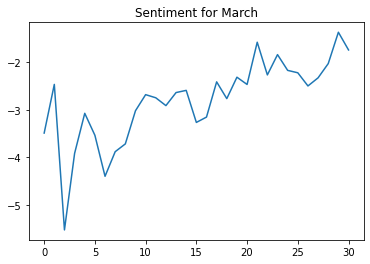

In [20]:
df.toPandas()["sentiment"].plot(title="Sentiment for March", legend=False)

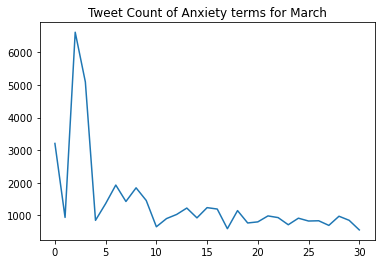

In [21]:
df.toPandas()["total_tweet"].plot(title="Tweet Count of Anxiety terms for March", legend=False)

### Plot Outbreak 

In [27]:
table_name = "janTweetsPolarity"
outbreak_file = "outbreak_terms.txt"

outbreak_terms = get_words_from_file(outbreak_file)
df = daily_polarity(table_name, outbreak_terms)

In [ ]:
df.toPandas()["total_tweet"].plot(title="Tweet Count of outbreak terms for March", legend=False)

In [ ]:
tweets = spark.sql("select * from janTweetsPolarity")

def plot_trend(chart_title, rolling_window=90):
    trend_pdf = tweets.select('created_at', 'polarity','id')\
                            .groupby('created_at').agg({'polarity':'avg','id':'count'})\
                            .orderBy('created_at')\
                            .withColumnRenamed('avg(polarity)','polarity')\
                            .withColumnRenamed('count(id)','num_tweets')\
                            .toPandas()
    print(trend_pdf.head(10)) 
    rolling_sentiment = trend_pdf.polarity.rolling(window=rolling_window).mean()
    rolling_tweets = trend_pdf.num_tweets.rolling(window=rolling_window).mean()
    print(rolling_sentiment.head(3))
    print(rolling_tweets.head(3)) 
    fig, ax = plt.subplots(figsize=(10,4), sharex=True)
    fig.suptitle('{}'.format(chart_title))
    ax0 = plt.subplot(111)
    ax1 = ax0.twinx()

    ax0.plot(trend_pdf.created_at, rolling_sentiment, label='sentiment_ma')
    ax0.legend(loc='upper left')
    ax1.plot(trend_pdf.created_at, rolling_tweets, label='tweets_ma', c='k')
    ax1.legend(loc='lower right');
plot_trend("demo", 3)

In [ ]:
# SNS experiments
import seaborn as sns; 
sns.set()
data = df.toPandas()
# date = pd.to_datetime(df['event_date'])
ax = sns.lineplot(data=data["total_tweet"])